In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font_scale=1.5)
from statannotations.Annotator import Annotator

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
# Create instances of the Modelling, Statistics, PrepEmotioncon, and Auxiliary classes
emo = emotioncon_modelling.Modelling() 
emostats = emotioncon_stats.Statistics() 
prep = prep_emotioncon.PrepEmotioncon()  
aux = auxiliary.Auxiliary()

mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']  # Define the mood categories as a list
group_label = ['control', 'distancing'] # Define the group label as a list
filepath = '../'  # Specify the file path
savefig = True
palette= {2: "plum", 3: "purple", 0: "lightgrey", 1: "grey"}

In [3]:
# Load data from a numpy file
data = np.load(filepath + 'results/fit_experiment.npy',allow_pickle='TRUE')

# Process the loaded data into a DataFrame, mood ratings, and other related variables
df, mood_ratings, foo = prep.create_df_from_dict(data)

# Create an empty array to store split mood ratings
mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), np.shape(mood_ratings)[1], \
                               np.shape(mood_ratings)[2], 2)) 
T = np.shape(mood_ratings[:,:,0])[0]  # Get the number of time points

# Split and store mood ratings based on time points
for t in range(2):
    mood_ratings_split[:,:,:,t] = mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:] 

# Create inputs based on videos shown during experiment
inp = emo.input_from_videos('../experiment/public/prep/videosForExperiment.csv')

# Calculate the number of subjects based on the length of the loaded data
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


----------------------------------------------------------------------------------------------------
Model Comparison:
--

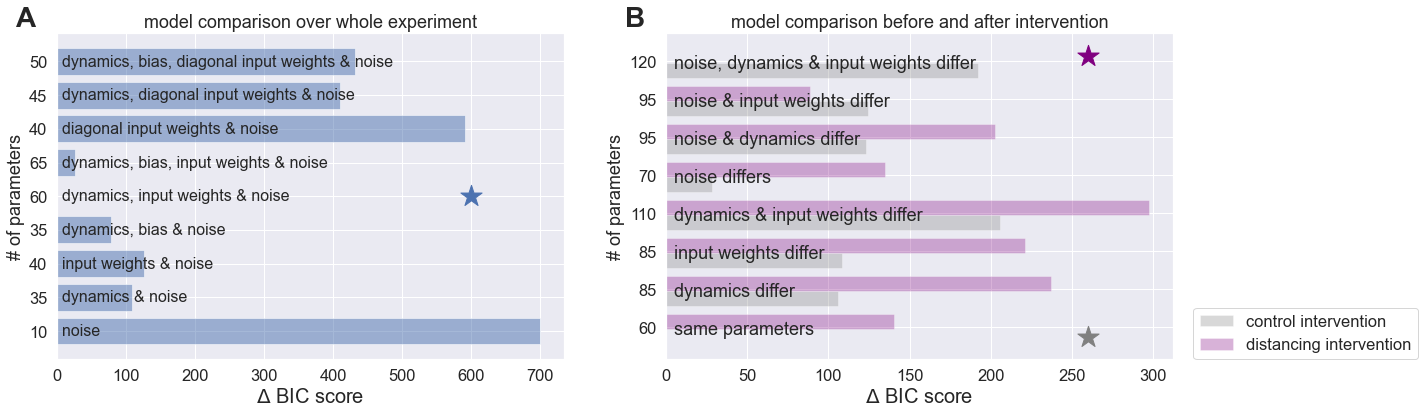

In [4]:
# Function to plot BIC scores for model comparison
def bic_plot(fig,axs,plot_number):

    fitting_labels = [['dynamics, bias, diagonal input weights & noise', \
                      'dynamics, diagonal input weights & noise', \
                      'diagonal input weights & noise', \
                      'dynamics, bias, input weights & noise', \
                      'dynamics, input weights & noise', \
                      'dynamics, bias & noise', \
                      'input weights & noise', \
                      'dynamics & noise', \
                      'noise'],
                     ['noise, dynamics & input weights differ', \
                      'noise & input weights differ', \
                      'noise & dynamics differ', \
                      'noise differs', \
                      'dynamics & input weights differ', \
                      'input weights differ', \
                      'dynamics differ', \
                      'same parameters']]

    condition_label = ['control intervention', 'distancing intervention']

    # subplot 1 BIC over whole time series
    # loglikelihood
    ll_all_subjects = np.empty((len(data[0]['ll']),Nsj))
    for i in range(Nsj):
        ll_all_subjects[:,i] = data[i]['ll']
    # calculate AIC and BIC 
    Ndatapoints = np.prod(np.shape(mood_ratings)[:2])
    aic, bic = emo.AICBIC_calc(np.nanmean(ll_all_subjects,axis=1), Ndatapoints*np.ones(len(data[0]['ll'])), \
                    np.array([10, 35, 40, 35, 60, 65, 40, 45, 50]))
    bic_whole = bic
    b = axs[0].barh(np.arange(len(bic_whole)), np.squeeze(np.array(bic_whole - min(bic_whole))), \
                    align='center', alpha=0.5)
    axs[0].set_yticks(range(len(data[0]['ll'])))
    axs[0].set_yticks(range(len(fitting_labels[0])))
    axs[0].set_yticklabels([10, 35, 40, 35, 60, 65, 40, 45, 50])
    axs[0].set_ylabel('# of parameters')
    axs[0].set_xlabel('$\Delta$ BIC score', fontsize=20);
    for bar, label in zip(axs[0].patches, fitting_labels[0][::-1]):
        axs[0].text(8, bar.get_y()+bar.get_height()/2, label, ha = 'left', va = 'center', size=16) 
    axs[0].set_xlabel('$\Delta$ BIC score', fontsize=20);
    axs[0].scatter(600, np.where(np.squeeze(np.array(bic - min(bic)))==0), marker = '*', s=500, \
              color=b.patches[0].get_facecolor()[:-1])
    axs[0].set_title('model comparison over whole experiment');
    axs[0].text(-0.08, 1.02, plot_number[0], transform=axs[0].transAxes, weight='bold', size=28)

    # subplot 2 split fitting in before and after intervention
    # loglikelihood
    ll_all_subjects = np.empty((len(data[0]['ll_split']),Nsj))
    for i in range(Nsj):
        ll_all_subjects[:,i] = data[i]['ll_split']
    width = 0.4
    for i in range(2):
        aic, bic = emo.AICBIC_calc(np.nanmean(ll_all_subjects[:,df['randomized_condition']==i],axis=1), \
                                   Ndatapoints*np.ones(len(data[0]['ll_split'])), \
                    np.array([60, 85, 85, 110, 70, 95, 95, 120]))
        b = axs[1].barh(np.arange(len(bic)) + i*width, np.squeeze(np.array(bic - min(bic))), width, \
                align='center', alpha=0.3, label=condition_label[i], color=palette[1+(i*2)])
        axs[1].scatter(260, np.where(np.squeeze(np.array(bic - min(bic)))==0)[0]+i*width, \
                   marker = '*', s=500, color=b.patches[0].get_facecolor()[:-1])
    axs[1].set_xlabel('$\Delta$ BIC score', fontsize=20);
    axs[1].set_title('model comparison before and after intervention')
    axs[1].set_yticks(np.arange(len(fitting_labels[1]))+0.25)
    axs[1].set_yticklabels([60, 85, 85, 110, 70, 95, 95, 120])
    axs[1].set_ylabel('# of parameters')
    axs[1].set_xlabel('$\Delta$ BIC score', fontsize=20);
    for bar, label in zip(axs[1].patches, fitting_labels[1][::-1]):
        axs[1].text(5, bar.get_y()+bar.get_height()/2 + width/2, label, ha = 'left', va = 'center', size=18)
    axs[1].legend(loc=[1.04,0]);
    axs[1].text(-0.08, 1.02, plot_number[1], transform=axs[1].transAxes, weight='bold', size=28)
     
fig, axs = plt.subplots(1,2, figsize=(20, 6))
sns.set(style='white', font_scale=1.5)
bic_plot(fig, axs, ['A', 'B'])
if savefig:
    plt.savefig(filepath + 'results/figures/bic_groups.png', bbox_inches='tight')

----------------------------------------------------------------------------------------------------
Simulated Data:
--

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_6552/3501681133.py:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  axs[i,4].text(1.1, 0.5, condition_label[df['randomized_condition'][sj]==1], \
/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_6552/3501681133.py:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  axs[i,4].text(1.1, 0.5, condition_label[df['randomized_condition'][sj]==1], \


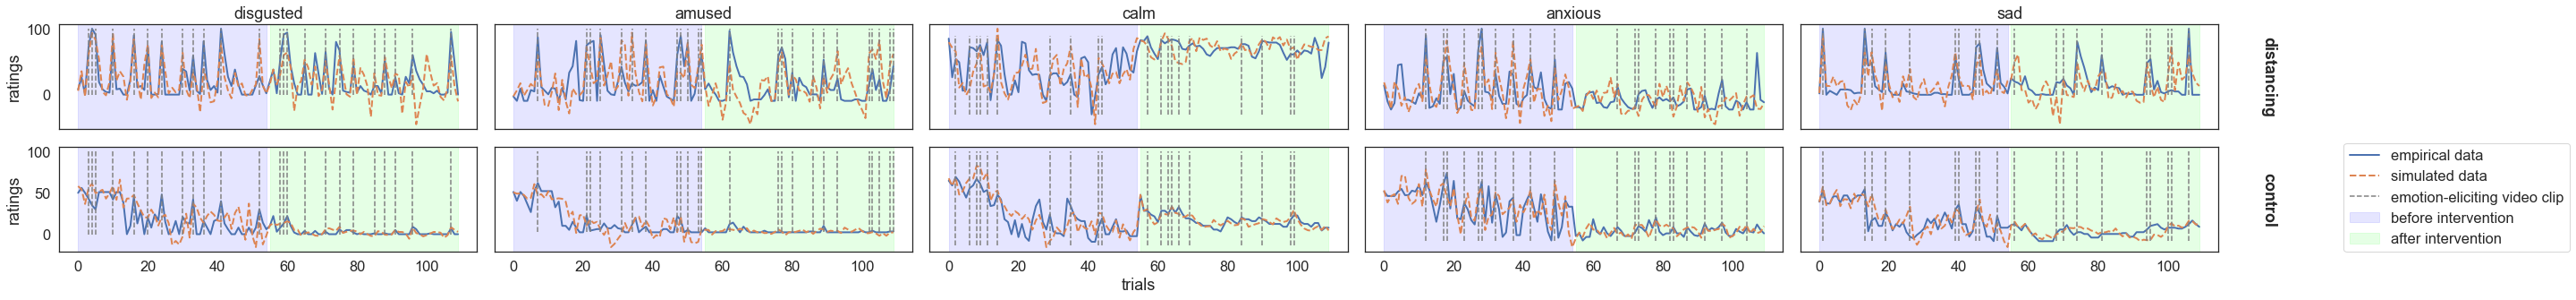

In [5]:
# Function to plot empirical and simulated time-series
def simulation_plot(fig, axs):
    random_sub = [16,61]
    condition_label = ['distancing', 'control']
    # random_sub = np.random.randint(1,Nsj,3)
    T = np.shape(data[0]['ratings'])[1]
    for i, sj in enumerate(random_sub):
        x = np.empty((T,5))
        for t in range(2):
            inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
            z, x[t*int(T/2):t*int(T/2) + int(T/2),:] = \
            data[sj]['results_split'][13+t].sample(int(T/2),  initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                    control_inputs=inp_split)

        for k in range(len(mood_categories)):
            axs[i,k].plot(mood_ratings[:,k,sj], linewidth=2);
            axs[i,k].plot(x[:,k], linestyle='--',linewidth=2);
            if i == 0: axs[i,k].set_title(mood_categories[k]);
            if k ==0: axs[i,k].set_ylabel('ratings');
            if i == 2: axs[i,k].set_xlabel('trials');
            axs[i,k].vlines(np.where(inp[:,k]), ymin=0, ymax=100, color='gray', linestyles = 'dashed')
            ylim = axs[i,k].get_ylim()
            axs[i,k].add_patch(plt.Rectangle((0, ylim[0]), 54, np.abs(ylim[0]) + ylim[1], \
                                             edgecolor=(0, 0, 1, 0.1), facecolor=(0, 0, 1, 0.1)))
            axs[i,k].add_patch(plt.Rectangle((55, ylim[0]), 54, np.abs(ylim[0]) + ylim[1], \
                                             edgecolor=(0, 1, 0, 0.1), facecolor=(0, 1, 0, 0.1)))
            if k != 0: axs[i,k].set_yticklabels([])
            if i != 1: axs[i,k].set_xticklabels([])
            if i == 1 and k == 2: axs[i,k].set_xlabel('trials')
        axs[i,4].text(1.1, 0.5, condition_label[df['randomized_condition'][sj]==1], \
                      transform=axs[i,4].transAxes, weight='bold', rotation=270, verticalalignment='center')
    plt.legend(['empirical data','simulated data', 'emotion-eliciting video clip', \
                'before intervention', 'after intervention'], loc=(1.3,0))
    plt.tight_layout()
    
fig, axs = plt.subplots(2,len(mood_categories),figsize=[40,5])
simulation_plot(fig, axs)
if savefig:
    plt.savefig(filepath + 'results/figures/modelfit_twoexamples.png')

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_6552/3501681133.py:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  axs[i,4].text(1.1, 0.5, condition_label[df['randomized_condition'][sj]==1], \
/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_6552/3501681133.py:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  axs[i,4].text(1.1, 0.5, condition_label[df['randomized_condition'][sj]==1], \


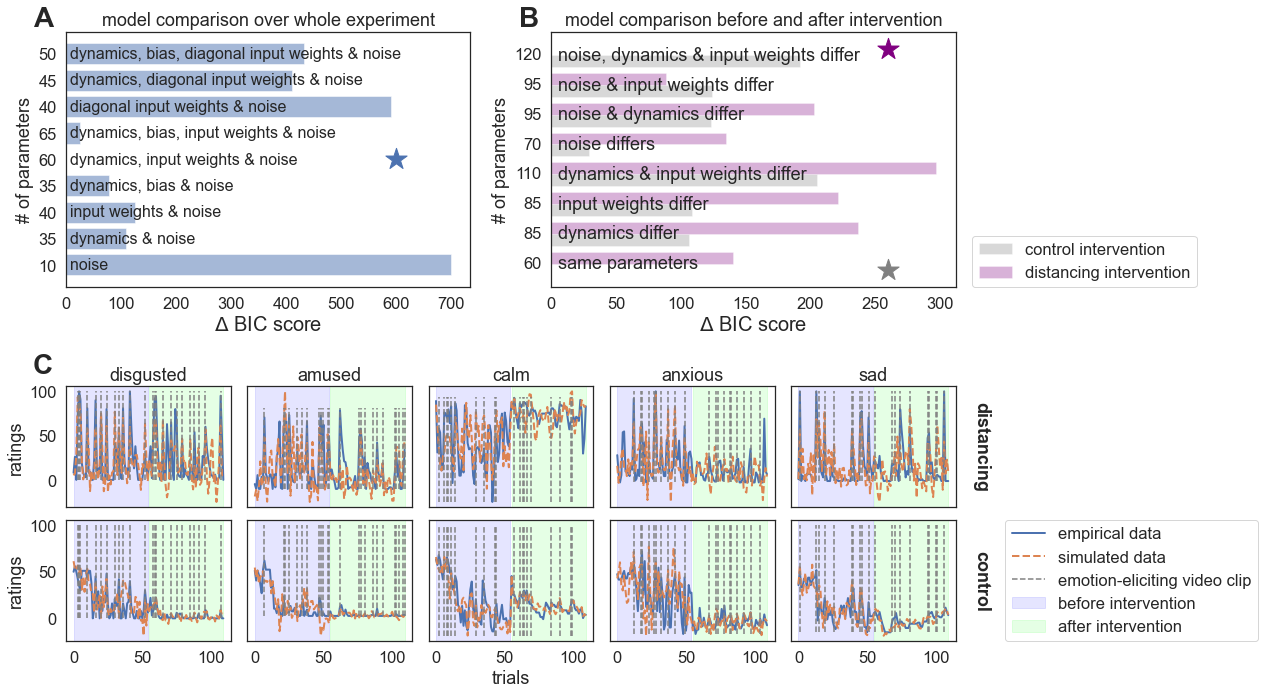

In [6]:
# Paperfigure 4 showing A) model comparison in whole sample over whole time course; B) split in groups before and after
# C) empirical vs generated data 
fig = plt.figure(figsize=(18, 10))
outer = gridspec.GridSpec(2, 1)
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0])
axs=[]
for i in range(2):
    ax = plt.Subplot(fig, inner[0,i])
    axs.append(fig.add_subplot(ax, sharey=ax, sharex=ax))
bic_plot(fig, axs, ['A', 'B'])

inner = gridspec.GridSpecFromSubplotSpec(2, len(mood_categories), hspace=0.1, wspace=0.1, subplot_spec=outer[1])
axs=[]
for i in range(2):
    axi=[]
    for m in range(len(mood_categories)):
        ax = plt.Subplot(fig, inner[i,m])
        axi.append(fig.add_subplot(ax, sharey=ax, sharex=ax))
    axs.append(axi)
axs[0][0].text(-0.04*5, 1.1, 'C', transform=axs[0][0].transAxes, weight='bold', size=28)
simulation_plot(fig,np.array(axs))
if savefig:
    plt.savefig(filepath + 'results/figures/modelling_results.svg')

---
Distancing Effects:
--

In [7]:
# Load data from the file without outliers
data_incl = np.load(filepath + 'results/fit_experiment_included.npy', allow_pickle=True)
df_incl, mood_ratings_incl, foo = prep.create_df_from_dict(data_incl)  # Create another DataFrame from the loaded data

# Rearrange data for statistics analysis
dynamics, controls = prep.rearrange_data_for_stats(data_incl)

# Calculate the total number of subjects
Nsj = len(data_incl)

# Print the number of subjects
print('N = ' + str(Nsj))

N = 104


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:199: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:, sj, k] = np.log(0.5) / np.log(e)


In [8]:
# Different statistics for within and between comparison for non-normal data
print('adjusted p-value: ' + str(np.round(0.05/15,3)))
def mean_pval(df, data):
    pval, statistics = np.empty((4,5)),  np.empty((4,5))
    for t in range(2):
        for i in range(5):
            dd = np.nanmean(data,axis=0)[i,:,t]
            statistics[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                       dd[df['randomized_condition']==1]).statistic
            pval[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                 dd[df['randomized_condition']==1]).pvalue
        for i in range(5):
            dd = np.nanmean(data,axis=0)[i,:,:]
            statistics[2+t,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==t,0],\
                                                   dd[df['randomized_condition']==t,1]).statistic
            pval[2+t,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==t,0],\
                                             dd[df['randomized_condition']==t,1]).pvalue
    return pval, statistics

adjusted p-value: 0.003


In [9]:
# Function to plot group differences in barplot with statistics
def plot_group_difference(df, data_labels, data_name=None, pvalues=None, pairs=None, \
                          fig=None, ax=None, title=None, legend=False):

    if pairs == None:
        pairs = []
        for t in range(2):
            for i in data_labels:
                pairs.append([(i, 0+t), (i, 2+t)])


    hue_plot_params = {
        'data': df,
        'x': 'category',
        'y': 'rating',
        "hue": "condition_time",
        "hue_order": [2, 0, 3, 1],
        "palette": {0: "lightgrey", 1: "grey", 2: "plum", 3: "purple"},
        "showmeans": True,
    }

    # Create new plot
    if fig == None: fig, ax = plt.subplots(figsize=[20,8])

    # Plot with seaborn
    b = sns.boxplot(ax=ax, **hue_plot_params)
    b.set_ylim(b.get_ylim()) # solves weird bug in annotator

    # Add annotations
    annotator = Annotator(b, pairs, **hue_plot_params);
    if pvalues is None: 
        annotator.configure(verbose=0, test='Mann-Whitney', comparisons_correction="Holm-Bonferroni")
        annotator.apply_and_annotate()
    else: 
        annotator.configure(verbose=0)
        annotator.set_pvalues_and_annotate(np.array(pvalues));
    
    b.set(xlabel='', ylabel='ratings', title=title)

    # Label and show
    if legend==True:
        b.legend(loc=(0.75, 1.05))
        b.legend_.texts[0].set_text('Before distancing intervention')
        b.legend_.texts[1].set_text('Before control intervention')
        b.legend_.texts[2].set_text('After distancing intervention')
        b.legend_.texts[3].set_text('After control intervention')
    else:
        b.legend().set_visible(False)
    return fig, b

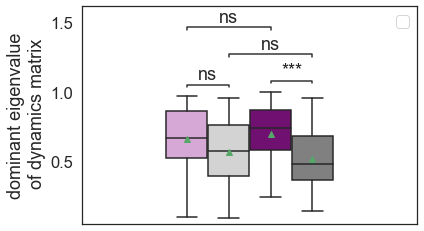

In [10]:
# Function to plot barplot with statistics
def plot_eigval(p,df,fig,ax,label=None, title=None, legend=False):
    pairs = []
    for t in range(2):
        pairs.append([('val', 0+t), ('val', 2+t)])
        pairs.append([('val', t+(t*1)), ('val', t+(t*1)+1)])
    plot_data = np.abs(p['val'][0,:,:])
    pval = []
    for t in range(2):
        tstats = scipy.stats.mannwhitneyu(plot_data[df['randomized_condition']==0,t], \
                                           plot_data[df['randomized_condition']==1,t])
        pval.append(tstats[1])
    Nsj = len(df)
    tmp = pd.DataFrame(np.hstack((plot_data[:,0], plot_data[:,1])), columns=['val'])
    tmp['time'] = np.hstack((np.zeros(Nsj),np.ones(Nsj)))
    tmp['condition'] = 2*df['randomized_condition'].to_list()
    tmp['condition_time'] = tmp['time'] + tmp['condition'] * 2
    df_melted = tmp.melt(id_vars=['condition_time'], value_vars=['val'], value_name='rating', var_name='category')
    fig,ax = emostats.plot_group_difference(df=df_melted, pairs=pairs, data_name= '', data_labels=['eigenval'], \
                                   fig=fig, ax=ax, show_legend=False, ms='Bonferroni')
    ax.set(ylabel='dominant ' + label, xlabel='', xticklabels='', title=title)

fig,ax = plt.subplots()
plot_eigval(dynamics,df_incl,fig,ax,'eigenvalue\n of dynamics matrix')

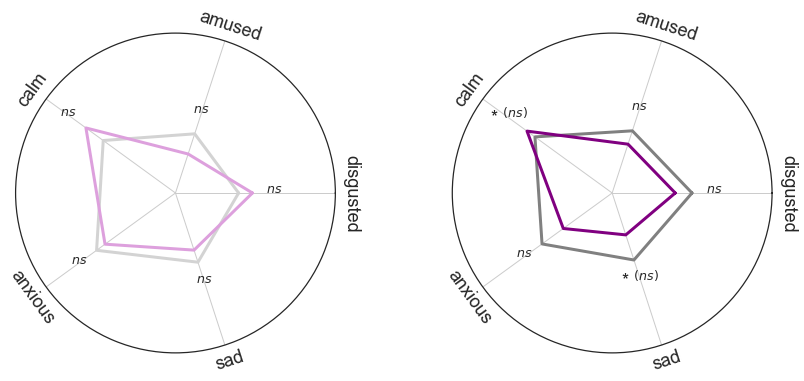

In [11]:
# Function to plot vectors in polar plot with statistics
def plot_eigvec(d,df,fig,axs,k,mood_categories):
    plot_data = d['absvec'][:,0,:,:]
    palette= {2: "plum", 3: "purple", 0: "lightgrey", 1: "grey"}
    medians = np.full((len(mood_categories)+1, 4), np.nan)
    pvalues = np.full((len(mood_categories), 4), np.nan)
    x = np.linspace(0, 2 * np.pi, len(mood_categories)+1)
    for i in range(2):
        for m in range(5):
            pvalues[m,i] = scipy.stats.wilcoxon(plot_data[m,df['randomized_condition']==i,0].T, \
                                                plot_data[m,df['randomized_condition']==i,1].T).pvalue
        for t in range(2):
            tmp = np.nanmedian(plot_data[:,df['randomized_condition']==i,t],axis=1)
            medians[:,t + (i*2)] = np.append(tmp, tmp[0])
            pvalues[:,2+t] = scipy.stats.mannwhitneyu(plot_data[:,df['randomized_condition']==0,t].T, \
                                                plot_data[:,df['randomized_condition']==1,t].T).pvalue
    ax = plt.subplot(3,4,5+k, polar=True)
    aux.polar_plot(medians[:,[0,2]], mood_categories, [palette[0], palette[2]], \
               ax, plt, pval=list(pvalues[:,2]))

    ax = plt.subplot(3,4,6+k, polar=True, sharey=ax)
    aux.polar_plot(medians[:,[1,3]], mood_categories, [palette[1], palette[3]], \
               ax, plt, pval=list(pvalues[:,3]))
    
data_label=['dynamics matrix', 'controllability matrix']
fig,ax = plt.subplots(2,1,figsize=(30, 20))
plot_eigvec(dynamics,df_incl, fig,ax,0,mood_categories)

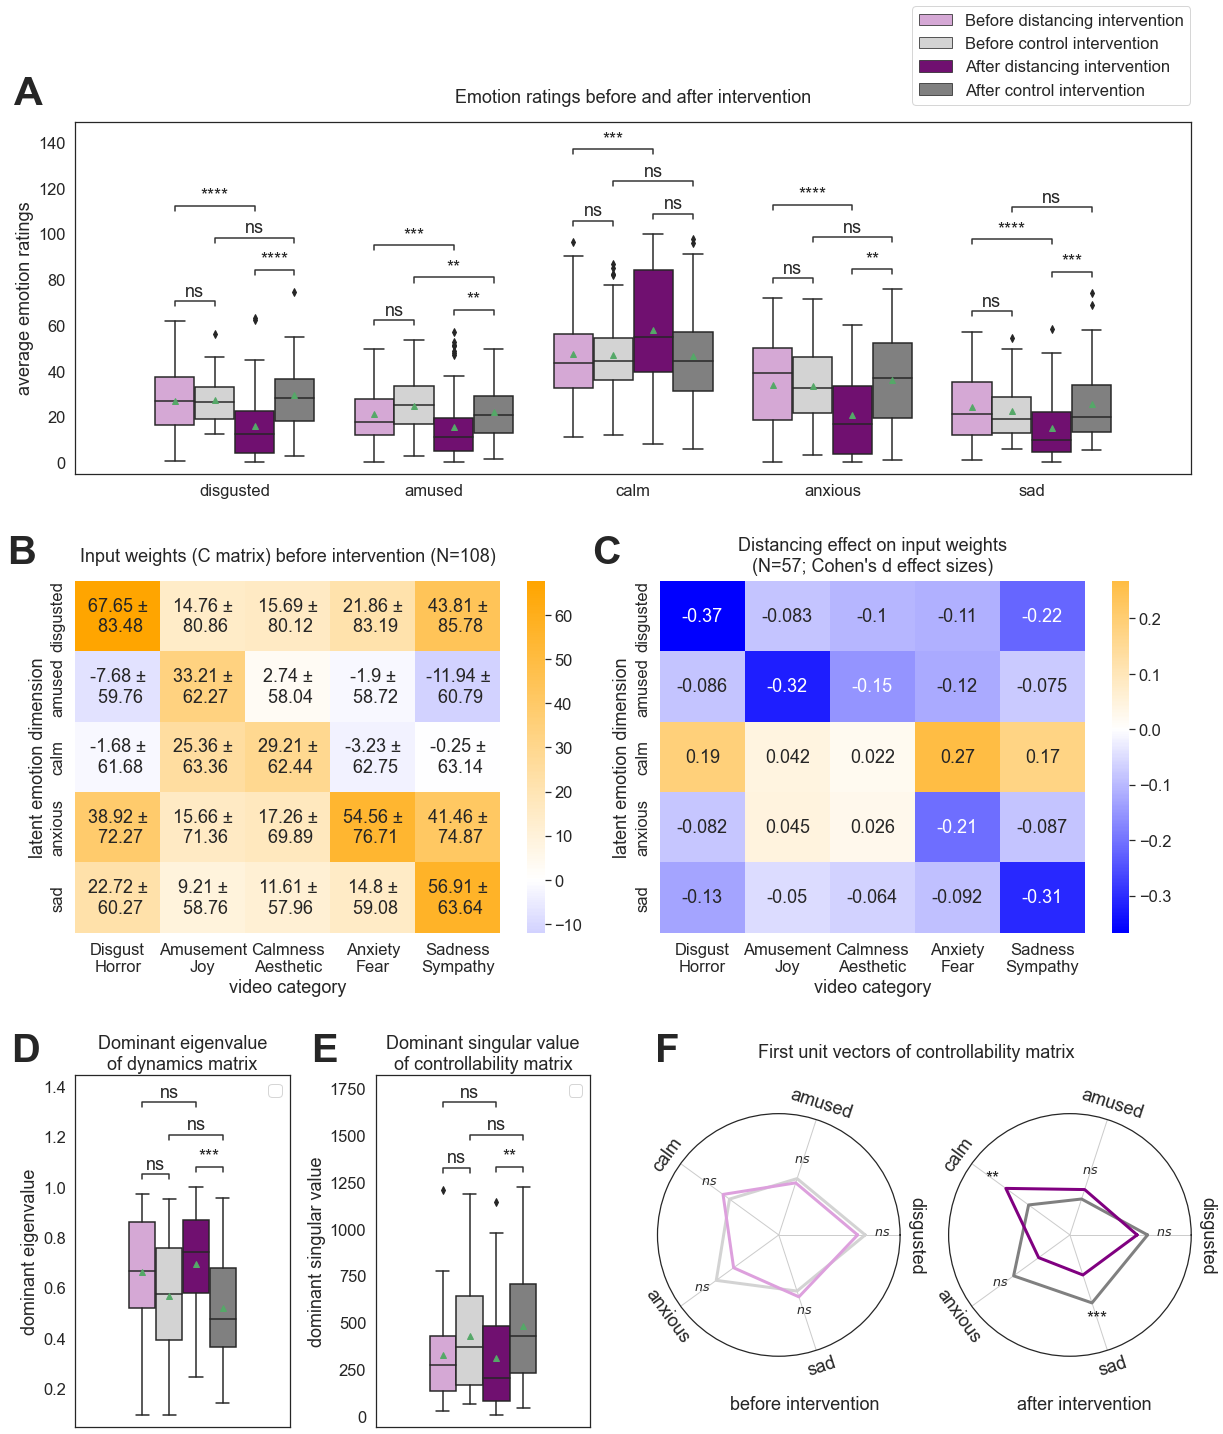

In [12]:
# Paper figure 5 Distnacing effect shown in A) mean ratings; B&C) input weights (C matrix); 
# D-F) eigenspectra of dynamics and controllability
import matplotlib.colors
PRGy = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","orange"])
sns.set(style='white', font_scale=1.5)
fig = plt.figure(figsize=(20, 24))
outer = gridspec.GridSpec(5, 1, height_ratios=[1,0.05,1,0.15,1], wspace=0.2)

# Plot mean ratings
ax = plt.Subplot(fig, outer[0])
axs = fig.add_subplot(ax)
df_melted = emostats.make_df(np.nanmean(mood_ratings_split,axis=0), df, mood_categories)

pairs = []
for t in range(2):
    for i in mood_categories:
        pairs.append([(i, 0+t), (i, 2+t)])
        pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])
        
pval, foo = mean_pval(df, mood_ratings_split)
pval_rearranged = np.empty(len(pairs))
for j, i in enumerate(pairs):
    if i[0][1] == 0 and i[1][1] == 2: x = 0
    elif i[0][1] == 1 and i[1][1] == 3: x = 1
    elif i[0][1] == 0 and i[1][1] == 1: x = 2
    else: x = 3
    pval_rearranged[j] = pval[x, np.where(np.array(mood_categories)==i[0][0])]
pval_corrected = statsmodels.stats.multitest.multipletests(pval_rearranged)[1]

plot_group_difference(df=df_melted, data_labels=mood_categories, data_name='emotion ratings', \
                      pairs=pairs, fig=fig, ax=axs, pvalues = pval_corrected, legend=True)
axs.set_title('Emotion ratings before and after intervention', pad=20)
axs.text(-0.055, 1.05, 'A', transform=axs.transAxes, weight='bold', size=40);
axs.set_ylabel('average emotion ratings')

categories_of_interest = ['Disgust', 'Amusement', 'Calmness', 'Anxiety', 'Sadness']
backup_category = ['Horror', 'Joy', 'Aesthetic', 'Fear', 'Sympathy']
xticklabels = [categories_of_interest[m] + '\n' + backup_category[m] for m in range(5)]

# Plot input weights (C matrix) before intervention
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[2], wspace=0.1)
axs=[]
for i in range(2):
    ax = plt.Subplot(fig, inner[0,i])
    axs.append(fig.add_subplot(ax))
p = controls['matrix']
a = np.round(np.nanmean(np.real(p[:,:,:,0]),axis=2),2).astype(str)
b = np.round(np.nanstd(np.real(p[:,:,:,0]),axis=2),2).astype(str)
annotation = np.array(a,dtype=object) + ' ±\n ' + np.array(b,dtype=object)
sns.heatmap(np.real(np.nanmean(p[:,:,:,0],axis=2)),ax=axs[0], \
            annot=annotation, fmt='', \
            xticklabels=xticklabels, \
            yticklabels=mood_categories, cmap=PRGy, center=0)

# Plot distancing effect on input weights (C matrix) in distancing group
diff = (controls['matrix'][:,:,df_incl['randomized_condition']==1,1] - \
 controls['matrix'][:,:,df_incl['randomized_condition']==1,0])
b=sns.heatmap(np.real((np.mean(diff,2) / np.std(diff,2))), annot=True, \
            xticklabels=xticklabels, \
              yticklabels=mood_categories, ax=axs[1], cmap=PRGy, center=0)
for i in range(2):
    axs[i].set(xlabel='video category', ylabel='latent emotion dimension');
    axs[i].set_title(['Input weights (C matrix) before intervention (N=' + str(len(df)) + ')', \
                      'Distancing effect on input weights\n(N=' + \
                      str(int(df['randomized_condition'].sum())) + "; Cohen's d effect sizes)"][i], pad=[20,10][i])
    
axs[0].text(-0.16, 1.05, 'B', transform=axs[0].transAxes, weight='bold', size=40)
axs[1].text(-0.16, 1.05, 'C', transform=axs[1].transAxes, weight='bold', size=40)

# Plot dominant eigenvalue of dynamics matrix and dominant singular value 
# as well as corresponding eigenvectors of controllability matrix
inner = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[4], wspace=0.4)
axs=[]
for i in range(4):
    ax = plt.Subplot(fig, inner[0,i])
    axs.append(fig.add_subplot(ax))

plot_eigval(dynamics,df_incl,fig,axs[0],'eigenvalue','Dominant eigenvalue\nof dynamics matrix')
plot_eigval(controls,df_incl,fig,axs[1],'singular value', 'Dominant singular value\nof controllability matrix')
plot_eigvec(controls,df_incl,fig,inner,6,mood_categories)
axs[0].text(3.92, 1.05, 'First unit vectors of controllability matrix', transform=axs[0].transAxes, ha='center')
axs[0].text(3.4, 0.05, 'before intervention', transform=axs[0].transAxes, ha='center')
axs[0].text(4.7, 0.05, 'after intervention', transform=axs[0].transAxes, ha='center')
axs[0].text(-0.3, 1.04, 'D', transform=axs[0].transAxes, weight='bold', size=40);
axs[1].text(-0.3, 1.04, 'E', transform=axs[1].transAxes, weight='bold', size=40);
axs[1].text(1.3, 1.04, 'F', transform=axs[1].transAxes, weight='bold', size=40);
if savefig:
    plt.savefig(filepath + 'results/figures/intervention_results.svg', bbox_inches='tight')